# Init

In [1]:
%matplotlib inline

import csv
import itertools
import math
import matplotlib
import time
import logging
import sys
import os
import random
import warnings

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags
from scipy.io import loadmat, savemat
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize, MultiLabelBinarizer
from gensim.models import KeyedVectors

In [2]:
from scoring import scoring
from fastrp_exp import *

In [3]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [4]:
%load_ext autoreload
%autoreload 2

# Load Data

## Blogcatalog

In [5]:
data_fname = 'example_graphs/blogcatalog.mat'

In [6]:
blogcatalog = loadmat(data_fname)
blog_labels = blogcatalog['group']
A = blogcatalog['network']
N = A.shape[0]

In [7]:
A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [8]:
N

10312

In [9]:
d = [l[0] for l in A.sum(axis=1).tolist()]

alpha=  1.258526391056572   sigma=  0.0025458536330247006


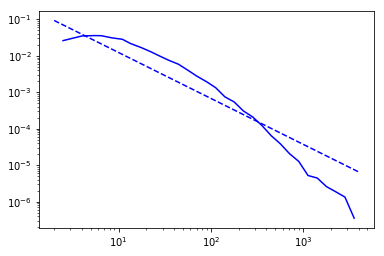

In [10]:
import powerlaw

fit = powerlaw.Fit(np.array(d)+1,xmin=1,discrete=True)
fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

# Measure Runtime

In [107]:
%%time
prefix = 'result/blog'
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 7.81, 45.28],
        'normalization': False,
        'dim': 512,
        'alpha': -0.628,
        'C': 1.0
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# savemat(emb_filename, {'emb': U})

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=False,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=1.0.mat
CPU times: user 2.55 ms, sys: 0 ns, total: 2.55 ms
Wall time: 1.9 ms


In [108]:
%time U = fastrp_wrapper(A, conf)

CPU times: user 5.64 s, sys: 360 ms, total: 6 s
Wall time: 1.17 s


In [89]:
savemat(emb_filename, {'emb': U})

In [90]:
%%time
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 20, 10)],
)
f1_scores

Train percent: 0.1
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.29212309243236917, 'macro': 0.1846801041650002}
-------------------
CPU times: user 1min 14s, sys: 341 ms, total: 1min 14s
Wall time: 33.5 s


# Intelligent Hyperparameter Search

In [92]:
import optuna

In [93]:
prefix = 'result/blog'

In [112]:
%%time
order_range = 1
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    weights = [trial.suggest_loguniform('weight' + str(order), 1.0, 64.0) for order in range(order_range)]
    alpha = trial.suggest_uniform('alpha', -1.0, 0.0)
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0, 0, 1] + weights,
        'normalization': True,
        'dim': 64,
        'alpha': alpha,
        'C': 0.1
    }
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = fastrp_wrapper(A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network","example_graphs/blogcatalog.mat",
            "--num-shuffles", "3",
            "--debug",
            "--C", str(conf['C']),
            "--training-percents", "10",
        ]
    )
    # there should only be one entry here
    return -f1_scores[0]['macro']

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=20)  # Invoke optimization of the objective function.

result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,25.35027555630504,alpha=-0.7589036552923178,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3247994555746552, 'macro': 0.1578946221768148}
-------------------


[I 2019-05-20 14:32:31,582] Finished trial#0 resulted in value: -0.1578946221768148. Current best value is -0.1578946221768148 with parameters: {'weight0': 25.35027555630504, 'alpha': -0.7589036552923178}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,4.288658943144085,alpha=-0.8673667445490716,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3324877127197408, 'macro': 0.1716169633994892}
-------------------


[I 2019-05-20 14:32:33,737] Finished trial#1 resulted in value: -0.1716169633994892. Current best value is -0.1716169633994892 with parameters: {'weight0': 4.288658943144085, 'alpha': -0.8673667445490716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,7.698621401927473,alpha=-0.8351448884676427,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3281579386618014, 'macro': 0.16612607471073626}
-------------------


[I 2019-05-20 14:32:35,664] Finished trial#2 resulted in value: -0.16612607471073626. Current best value is -0.1716169633994892 with parameters: {'weight0': 4.288658943144085, 'alpha': -0.8673667445490716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.7641479169374845,alpha=-0.35976587356827716,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3333008209258715, 'macro': 0.17319907470965248}
-------------------


[I 2019-05-20 14:32:37,568] Finished trial#3 resulted in value: -0.17319907470965248. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,3.4139600102359364,alpha=-0.011592552506729192,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3289950991796669, 'macro': 0.16004893668750222}
-------------------


[I 2019-05-20 14:32:39,497] Finished trial#4 resulted in value: -0.16004893668750222. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,10.24561526097156,alpha=-0.22601603194954545,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.335672639940006, 'macro': 0.1652807042028017}
-------------------


[I 2019-05-20 14:32:41,424] Finished trial#5 resulted in value: -0.1652807042028017. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,1.192199714006375,alpha=-0.7977006562836445,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3259676782641558, 'macro': 0.1695127421275389}
-------------------


[I 2019-05-20 14:32:43,367] Finished trial#6 resulted in value: -0.1695127421275389. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,29.257664696846046,alpha=-0.22580446184967384,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3299235836786291, 'macro': 0.1592582035050475}
-------------------


[I 2019-05-20 14:32:45,369] Finished trial#7 resulted in value: -0.1592582035050475. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.1087871263828473,alpha=-0.16099511198978378,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3182149617368916, 'macro': 0.15515171954219084}
-------------------


[I 2019-05-20 14:32:47,200] Finished trial#8 resulted in value: -0.15515171954219084. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,4.492318467621318,alpha=-0.3304916019810441,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3312371366250659, 'macro': 0.16960445243549072}
-------------------


[I 2019-05-20 14:32:49,167] Finished trial#9 resulted in value: -0.16960445243549072. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,1.0929395684423973,alpha=-0.5641039086981745,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3200290608091943, 'macro': 0.16458340494764362}
-------------------


[I 2019-05-20 14:32:50,967] Finished trial#10 resulted in value: -0.16458340494764362. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,13.078291441186105,alpha=-0.47479794450262625,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3293480372915586, 'macro': 0.16193432989922865}
-------------------


[I 2019-05-20 14:32:52,901] Finished trial#11 resulted in value: -0.16193432989922865. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,1.0626346571914238,alpha=-0.6069540009947277,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.31846171448896216, 'macro': 0.16617536859874624}
-------------------


[I 2019-05-20 14:32:54,842] Finished trial#12 resulted in value: -0.16617536859874624. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,51.51954071900352,alpha=-0.9682812491762334,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.32265447702472266, 'macro': 0.15878135009253258}
-------------------


[I 2019-05-20 14:32:56,713] Finished trial#13 resulted in value: -0.15878135009253258. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.2619984819272485,alpha=-0.4509629672136868,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.32358122080110285, 'macro': 0.16395220402863567}
-------------------


[I 2019-05-20 14:32:58,677] Finished trial#14 resulted in value: -0.16395220402863567. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,2.2806658056222107,alpha=-0.09395912852593447,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.329366733077529, 'macro': 0.16895404478694878}
-------------------


[I 2019-05-20 14:33:00,527] Finished trial#15 resulted in value: -0.16895404478694878. Current best value is -0.17319907470965248 with parameters: {'weight0': 2.7641479169374845, 'alpha': -0.35976587356827716}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,6.504182347849674,alpha=-0.6506855353616028,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.332139330436869, 'macro': 0.17338782471467395}
-------------------


[I 2019-05-20 14:33:02,472] Finished trial#16 resulted in value: -0.17338782471467395. Current best value is -0.17338782471467395 with parameters: {'weight0': 6.504182347849674, 'alpha': -0.6506855353616028}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,6.667928455970716,alpha=-0.6414724466236545,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3342296508481968, 'macro': 0.1744284220153279}
-------------------


[I 2019-05-20 14:33:04,390] Finished trial#17 resulted in value: -0.1744284220153279. Current best value is -0.1744284220153279 with parameters: {'weight0': 6.667928455970716, 'alpha': -0.6414724466236545}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,6.828770263291829,alpha=-0.6715812260129261,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.3326372204342953, 'macro': 0.17008692348121937}
-------------------


[I 2019-05-20 14:33:06,241] Finished trial#18 resulted in value: -0.17008692348121937. Current best value is -0.1744284220153279 with parameters: {'weight0': 6.667928455970716, 'alpha': -0.6414724466236545}.


result/blog-dim=64,projection_method=sparse,input_matrix=trans,normalization=True,weights=0,0,1,16.003689823549568,alpha=-0.6863129335864669,C=0.1.mat
Train percent: 0.1
Results, using embeddings of dimensionality 64
-------------------
Train percent: 0.1
Average score: {'micro': 0.32630619204046624, 'macro': 0.1628392993079853}
-------------------


[I 2019-05-20 14:33:08,270] Finished trial#19 resulted in value: -0.1628392993079853. Current best value is -0.1744284220153279 with parameters: {'weight0': 6.667928455970716, 'alpha': -0.6414724466236545}.


CPU times: user 8min 35s, sys: 653 ms, total: 8min 36s
Wall time: 38.9 s


In [113]:
study.best_params

{'weight0': 6.667928455970716, 'alpha': -0.6414724466236545}

In [115]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, 1.0, 6.67],
        'normalization': True,
        'dim': 512,
        'alpha': -0.64,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = fastrp_wrapper(A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
f1_scores

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,1.0,6.67,alpha=-0.64,C=0.1.mat
File result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,1.0,6.67,alpha=-0.64,C=0.1.mat already exists, skipped.
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.37227020685494977, 'macro': 0.22810176026637136}
-------------------
Train percent: 0.2
Average score: {'micro': 0.3907265679401467, 'macro': 0.24936234429670506}
-------------------
Train percent: 0.3
Average score: {'micro': 0.399829596612806, 'macro': 0.2587104513975861}
-------------------
Train percent: 0.4
Average score: {'micro': 0.40738907903529603, 'macro': 0.2691895694524022}
-------------------
T

In [104]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, 1.0, 4.836],
        'normalization': True,
        'dim': 512,
        'alpha': -0.6,
        'C': 1.0
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = fastrp_wrapper(A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 20, 10)],
)
f1_scores

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,1.0,4.836,alpha=-0.6,C=1.0.mat
Train percent: 0.1
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3403260570840879, 'macro': 0.2176648356781609}
-------------------
CPU times: user 1min 56s, sys: 1.25 s, total: 1min 58s
Wall time: 50.3 s


In [99]:
study.best_params

{'weight0': 10.839989749509,
 'weight1': 33.400321987814756,
 'alpha': -0.9050407667591776}

In [65]:
study.best_value

-0.3572280985847538

In [37]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [0.0, 0.0, 7.81, 45.28],
        'normalization': True,
        'dim': 512,
        'alpha': -0.628,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(blog_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 20, 10)],
)
f1_scores

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,7.81,45.28,beta=,C=0.1.mat
File result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=0.0,0.0,7.81,45.28,beta=,C=0.1.mat already exists, skipped.
Train percent: 0.1
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3757665796564458, 'macro': 0.23151573878816514}
-------------------
CPU times: user 1min 31s, sys: 218 ms, total: 1min 32s
Wall time: 34.6 s


In [47]:
labels_count = blog_labels.shape[1]
mlb = MultiLabelBinarizer(range(labels_count))

In [49]:
x = f1_score(mlb.fit_transform(y_test), mlb.fit_transform(preds), average='macro')
x

0.228355566826923

In [38]:
(y_test, preds, indices_test) = result

In [43]:
y_test[:4]

[[4], [1], [1], [10]]

In [44]:
preds[:4]

[[4], [5], [1], [10]]

In [70]:
%%time

conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, 7.81, 45.28],
        'normalization': True,
        'dim': 512,
        'alpha': -0.628,
        'C': 0.1
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = randne_wrapper(blog_A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores = scoring(
    [
        "--emb", emb_filename,
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
f1_scores

result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=0.1.mat
File result/blog-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.81,45.28,alpha=-0.628,C=0.1.mat already exists, skipped.
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3710668138287513, 'macro': 0.2315109317900343}
-------------------
Train percent: 0.2
Average score: {'micro': 0.385981757405288, 'macro': 0.24859995274320168}
-------------------
Train percent: 0.3
Average score: {'micro': 0.3923432215400081, 'macro': 0.2596759611974167}
-------------------
Train percent: 0.4
Average score: {'micro': 0.3995747775381412, 'macro': 0.26698977271665997}
-----------------

# DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input example_graphs/blogcatalog.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 28 --output example_graphs/blogcatalog.emb &

Load DeepWalk embeddings:

In [69]:
dw_emb_fname = '/home/hcchen/deepwalk/example_graphs/blogcatalog.emb'

In [73]:
model = KeyedVectors.load_word2vec_format(dw_emb_fname, binary=False)

In [74]:
N = len(model.vocab)
%time dw_emb = np.asarray([model[str(node)] for node in range(N)])

CPU times: user 24.4 ms, sys: 4.03 ms, total: 28.4 ms
Wall time: 27.9 ms


In [75]:
dw_emb.shape

(10312, 128)

In [133]:
%%time
f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk/example_graphs/blogcatalog.emb",
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1",
        "--training-percents",
    ] + [str(p) for p in range(10, 20, 10)],
)
f1_scores

39
(10312, 128)
Train percent: 0.1
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.36430591441992466, 'macro': 0.21338703677799015}
-------------------
CPU times: user 41.7 s, sys: 144 ms, total: 41.8 s
Wall time: 4.9 s


# RandNE

In [ ]:
cd ~/RandNE-Python/ && 
time python3 src/randne.py --input /home/hcchen/fast-random-projection/example_graphs/blogcatalog.mat \
--output /home/hcchen/fast-random-projection/result/blog-randne-emb.mat \
--use-trans-matrix -q 3 -d 512 --weights 1 100 1000

In [9]:
randne_f1_scores = scoring(
    [
        "--emb", "result/blog-randne-emb.mat",
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
randne_f1_scores

Shape:  (10312, 512)
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.1
Average score: {'micro': 0.3385352110064831, 'macro': 0.20876822244386956}
-------------------
Train percent: 0.2
Average score: {'micro': 0.35823398182675614, 'macro': 0.23121345760670642}
-------------------
Train percent: 0.3
Average score: {'micro': 0.3716429726123654, 'macro': 0.24612310059441364}
-------------------
Train percent: 0.4
Average score: {'micro': 0.38175652894989, 'macro': 0.2540813403943384}
-------------------
Train percent: 0.5
Average score: {'micro': 0.38617265642373544, 'macro': 0.25883527270272333}
-------------------
Train percent: 0.6
Average score: {'micro': 0.39452065914503787, 'macro': 0.2689658934746254}
-------------------
Train percent: 0.7000000000000001
Average 

[defaultdict(float,
             {'micro': 0.3385352110064831,
              'macro': 0.20876822244386956,
              'training': 0.1}),
 defaultdict(float,
             {'micro': 0.35823398182675614,
              'macro': 0.23121345760670642,
              'training': 0.2}),
 defaultdict(float,
             {'micro': 0.3716429726123654,
              'macro': 0.24612310059441364,
              'training': 0.3}),
 defaultdict(float,
             {'micro': 0.38175652894989,
              'macro': 0.2540813403943384,
              'training': 0.4}),
 defaultdict(float,
             {'micro': 0.38617265642373544,
              'macro': 0.25883527270272333,
              'training': 0.5}),
 defaultdict(float,
             {'micro': 0.39452065914503787,
              'macro': 0.2689658934746254,
              'training': 0.6}),
 defaultdict(float,
             {'micro': 0.4002016678995253,
              'macro': 0.2721048131721807,
              'training': 0.7000000000000001}),
 defaul

# Node2vec

Import A as edgelist:

In [116]:
A

<10312x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 667966 stored elements in Compressed Sparse Column format>

In [118]:
G = nx.from_scipy_sparse_matrix(A)
G.number_of_nodes(), G.number_of_edges()

(10312, 333983)

In [119]:
nx.write_edgelist(G, open('/home/hcchen/node2vec/graph/blogcatalog.edgelist', 'wb'))

Run node2vec:

In [ ]:
cd /home/hcchen/node2vec && nohup time python2 src/main.py \
--input /home/hcchen/node2vec/graph/blogcatalog.edgelist \
--num-walks 80 --dimensions 128 --walk-length 40 --window-size 10 \
--p 0.25 --q 0.25 \
--workers 40 --output emb/blogcatalog.node2vec.emb &

In [ ]:
cd /home/hcchen/deepwalk-sgns/deepwalk && nohup time python __main__.py --format mat \
--input /home/hcchen/deepwalk/example_graphs/blogcatalog.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 40 --output /home/hcchen/deepwalk-sgns/example_graphs/blogcatalog.node2vec.emb &

In [124]:
%%time
f1_scores = scoring(
    [
        "--emb", "/home/hcchen/deepwalk-sgns/example_graphs/blogcatalog.node2vec.emb",
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
f1_scores

(10312, 128)
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.35286345334054525, 'macro': 0.16246433344400618}
-------------------
Train percent: 0.2
Average score: {'micro': 0.38607160391394235, 'macro': 0.19888426916622984}
-------------------
Train percent: 0.3
Average score: {'micro': 0.39964362431890577, 'macro': 0.21944826907523768}
-------------------
Train percent: 0.4
Average score: {'micro': 0.4100233094842819, 'macro': 0.2348868760288781}
-------------------
Train percent: 0.5
Average score: {'micro': 0.41931793450052524, 'macro': 0.24508157502904537}
-------------------
Train percent: 0.6
Average score: {'micro': 0.42615692195290344, 'macro': 0.25077994482951993}
-------------------
Train percent: 0.7000000000000001
Average sco

In [135]:
%%time
f1_scores = scoring(
    [
        "--emb", "/home/hcchen/node2vec/emb/blogcatalog.node2vec.emb",
        "--network","example_graphs/blogcatalog.mat",
        "--num-shuffles", "5",
        "--debug",
        "--C", "1",
        "--training-percents",
    ] + [str(p) for p in range(10, 100, 10)],
)
f1_scores

(10312, 128)
Train percent: 0.1
Train percent: 0.2
Train percent: 0.3
Train percent: 0.4
Train percent: 0.5
Train percent: 0.6
Train percent: 0.7000000000000001
Train percent: 0.8
Train percent: 0.9
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.1
Average score: {'micro': 0.3591180070081537, 'macro': 0.21186082537357653}
-------------------
Train percent: 0.2
Average score: {'micro': 0.38265617540570335, 'macro': 0.24130518483228275}
-------------------
Train percent: 0.3
Average score: {'micro': 0.3991142579958692, 'macro': 0.26102802369713}
-------------------
Train percent: 0.4
Average score: {'micro': 0.4078603428194727, 'macro': 0.27041940163774725}
-------------------
Train percent: 0.5
Average score: {'micro': 0.4164145388651012, 'macro': 0.2770733369602342}
-------------------
Train percent: 0.6
Average score: {'micro': 0.4206027010473715, 'macro': 0.28418770276838734}
-------------------
Train percent: 0.7000000000000001
Average score: {'m

# Embedding Space Properties

In [50]:
from sklearn.metrics.pairwise import euclidean_distances

We can take a specific node (maybe chosen based on its degree) and plot the distribution of the L2 distance between its embeddings and all other nodes. Can we see a difference here? Is it different from Flickr or Blogcatalog?

First take a high degree node:

In [67]:
ind = 14

In [68]:
A[ind]

<1x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 216 stored elements in Compressed Sparse Column format>

Compute its L2 distance to all the other nodes in the embedding space for DeepWalk and random projection:

In [107]:
dw_l2_distance_high = euclidean_distances([dw_emb[ind]], dw_emb)

In [108]:
rp_l2_distance_high = euclidean_distances([U[ind]], U)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


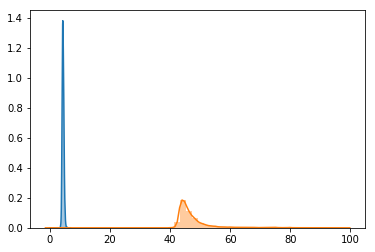

In [109]:
sns.distplot(dw_l2_distance_high)
sns.distplot(rp_l2_distance_high)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


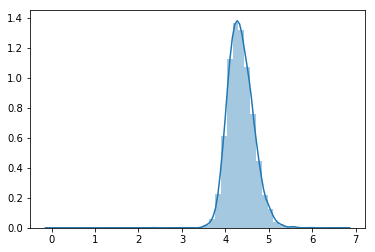

In [110]:
sns.distplot(dw_l2_distance_high)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


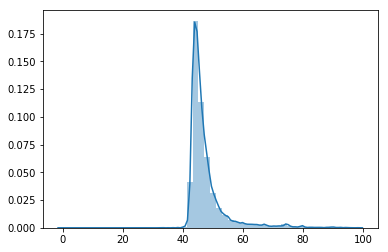

In [111]:
sns.distplot(rp_l2_distance_high)

Then take a mid-degree node:

In [83]:
ind = 20

In [84]:
A[ind]

<1x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Column format>

Compute its L2 distance to all the other nodes in the embedding space:

In [104]:
dw_dist_mid = euclidean_distances([dw_emb[ind]], dw_emb)

In [105]:
rp_dist_mid = euclidean_distances([U[ind]], U)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


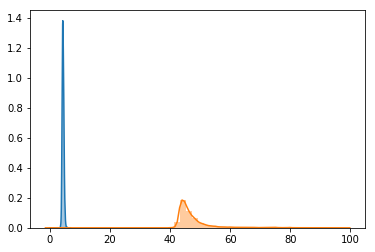

In [106]:
sns.distplot(dw_dist_mid)
sns.distplot(rp_dist_mid)

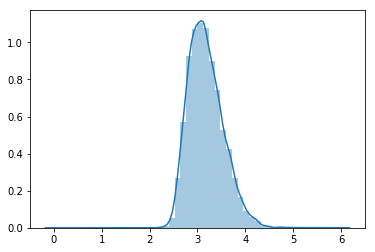

In [99]:
sns.distplot(dw_dist_mid)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


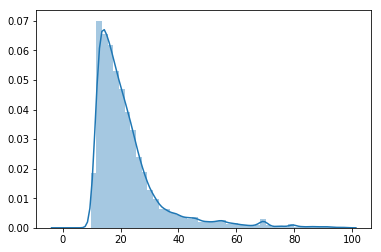

In [100]:
sns.distplot(rp_dist_mid)

Then take a low-degree node:

In [92]:
ind = 1236

In [93]:
A[ind]

<1x10312 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Column format>

Compute its L2 distance to all the other nodes in the embedding space:

In [94]:
dw_dist_low = euclidean_distances([dw_emb[ind]], dw_emb)

In [95]:
rp_dist_low = euclidean_distances([U[ind]], U)

/home/hcchen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


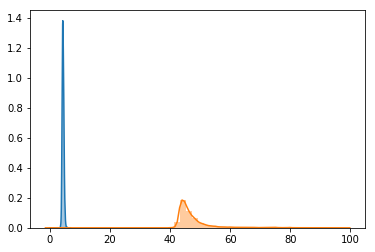

In [96]:
sns.distplot(dw_dist_low)
sns.distplot(rp_dist_low)

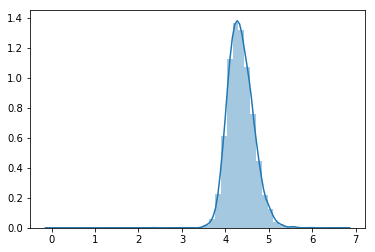

In [97]:
sns.distplot(dw_dist_low)

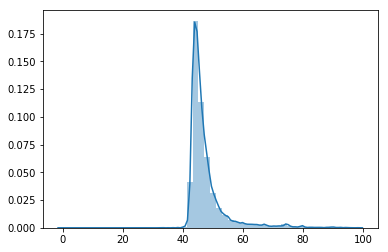

In [98]:
sns.distplot(rp_dist_low)